In [1]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import numpy as np
import sklearn

from sklearn.model_selection import train_test_split

## Load Train and Test Datasets

In [2]:
# Load training data
df_train = pd.read_csv('Datasets/CICIDS-2017_train.csv')

In [3]:
# Load testing data
df_test = pd.read_csv('Datasets/CICIDS-2017_test.csv')

In [4]:
X_train = df_train.drop(['label'], axis=1)  # Features
y_train = df_train['label']  # Target variable

In [5]:
X_test = df_test.drop(['label'], axis=1)  # Features
y_test = df_test['label']  # Target variable

## Load Model

In [6]:
# Save the trained model to a specific folder
model_folder = "saved_model/"
model_filename = "CICIDS-2017_XGBoost.joblib"
model_path = model_folder + model_filename

model = joblib.load(model_path)

# Feature Importance

In [7]:
feature_names = df_train.columns
feature_names = feature_names[:-1]

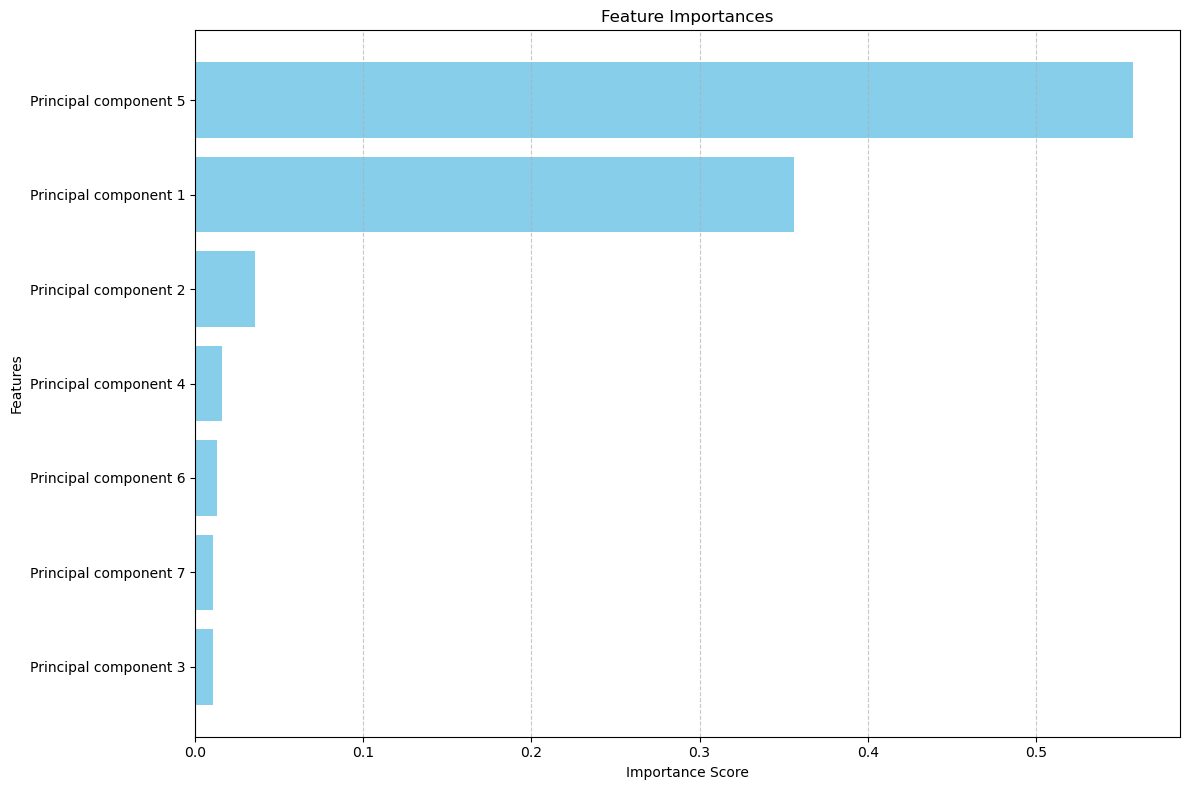

In [8]:
# Get feature importances
importances = model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
fig, ax = plt.subplots(figsize=(12, 8))

# Create horizontal bar plot
ax.barh(range(X_train.shape[1]), importances[indices], color="skyblue")

# Set y-axis labels
ax.set_yticks(range(X_train.shape[1]))
ax.set_yticklabels(feature_names[indices])

# Set title and labels
ax.set_title("Feature Importances")
ax.set_xlabel("Importance Score")
ax.set_ylabel("Features")

# Invert y-axis for better readability
ax.invert_yaxis()

# Add grid for better visualization
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Tight layout
plt.tight_layout()

# Show the plot
plt.show()

In [9]:
def calculate_feature_importance(model, feature_names):
    """
    Calculate feature importance using Gini index.

    Returns:
    - DataFrame: DataFrame containing feature names and their corresponding Gini importance.
    """
    # Create DataFrame to hold feature names
    dfp_importance = pd.DataFrame({'feat_names': feature_names})
    dfp_importance['feature'] = dfp_importance.index.astype(str)  

    # Create DataFrame to hold Gini importance
    dfp_importance_gini = pd.DataFrame({'importance_gini': model.feature_importances_})
    dfp_importance_gini['feature'] = dfp_importance_gini.index.astype(str)  

    # Calculate percentile rank of Gini importance
    dfp_importance_gini['importance_gini_pct'] = dfp_importance_gini['importance_gini'].rank(pct=True)

    # Merge DataFrames and sort by importance
    dfp_importance = pd.merge(dfp_importance, dfp_importance_gini, on='feature', how='left')
    dfp_importance = dfp_importance.sort_values(by=['importance_gini', 'feature'], ascending=[False, True]).reset_index(drop=True)
    
    return dfp_importance

%time importance_table = calculate_feature_importance(model, feature_names)
importance_table

CPU times: total: 0 ns
Wall time: 14.6 ms


,feat_names,feature,importance_gini,importance_gini_pct
0,Principal component 5,4,0.557737,1.000000
1,Principal component 1,0,0.355984,0.857143
2,Principal component 2,1,0.035474,0.714286
3,Principal component 4,3,0.016305,0.571429
4,Principal component 6,5,0.013070,0.428571
5,Principal component 7,6,0.010836,0.285714
6,Principal component 3,2,0.010594,0.142857


## Shap

In [10]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


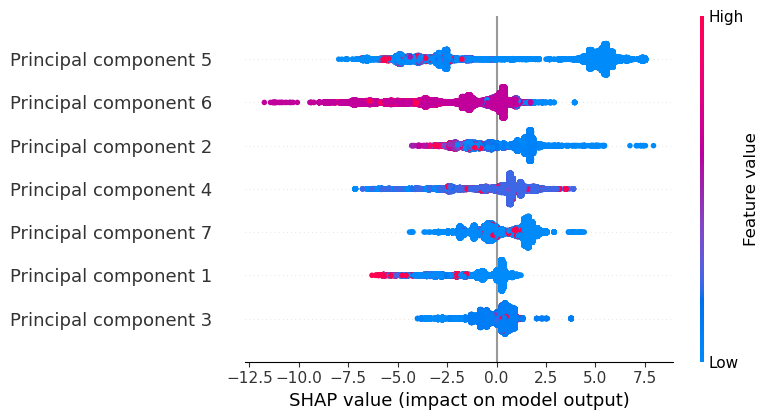

CPU times: total: 1min 38s
Wall time: 7.61 s


In [11]:
import shap

def visualize_shap_summary_plot(model, X_test, feature_names=None, class_names=None):
    """
    Visualize SHAP summary plot for interpreting model predictions.
    """
    # Create a SHAP explainer for the model
    explainer = shap.TreeExplainer(model)  

    # Calculate SHAP values for the test dataset
    shap_values = explainer.shap_values(X_test)

    # Visualize the SHAP summary plot
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, class_names=class_names)

%time visualize_shap_summary_plot(model, X_test, feature_names=feature_names, class_names=['Normal', 'Malicious'])

## InterpretML

In [12]:
pip install interpret

Note: you may need to restart the kernel to use updated packages.


In [13]:
from interpret.blackbox import MorrisSensitivity
from sklearn.pipeline import Pipeline
from interpret import show

%time msa = MorrisSensitivity(model, X_test,feature_names=feature_names)

show(msa.explain_global())

CPU times: total: 1.73 s
Wall time: 322 ms


<!-- http://127.0.0.1:7001/3058836991632/ -->

In [17]:
pip install lime

     ---------------------------------------- 0.0/275.7 kB ? eta -:--:--
     ---- -------------------------------- 30.7/275.7 kB 435.7 kB/s eta 0:00:01
     ---------- -------------------------- 81.9/275.7 kB 919.0 kB/s eta 0:00:01
     ----------------------- -------------- 174.1/275.7 kB 1.2 MB/s eta 0:00:01
     -------------------------------------- 275.7/275.7 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283846 sha256=3bb6d42b420d81aaf7b104268a13c753f1fdbb9c8d62a4f5c9d121f4e7d69dc5
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\85\fa\a3\9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
Note: you may need to restart the kernel to use updated packages.


In [18]:
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    X_train.values,  # X_train is your training dataset
    mode="classification",
    training_labels=y_train,  # y_train is the target variable
    feature_names=X_train.columns
)

# Explain a single prediction
i = 0  # index of the instance you want to explain
exp = explainer.explain_instance(X_test.iloc[i], model.predict_proba)
exp.show_in_notebook()


c:\Users\User\anaconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\User\anaconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

c:\Users\User\anaconda3\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\User\anaconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning:

Series.__ge

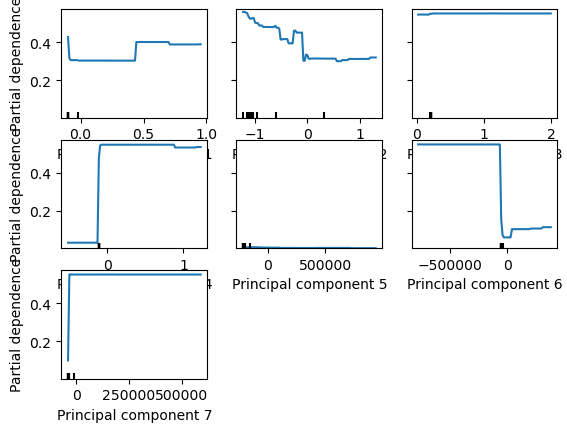

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

# Assuming 'model' is your trained model and 'X' is your dataset
PartialDependenceDisplay.from_estimator(model, X_test, features=[0,1,2,3,4,5,6])  
plt.show()
